# Gut Microbiome Exploratory Data Analysis (EDA)
Alpha and Beta Diversity, Initial analysis

In [1]:
import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
from scipy import stats
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import kruskal

sns.set(style="whitegrid", font_scale=1.05)
np.random.seed(2025)


# 1. Setup & Data Loading

In [2]:
# Create directories
data_dir = "data"
RESULTS = os.path.join(data_dir, "results_EDA")
FIGS = os.path.join(RESULTS, "figures")
TABLES = os.path.join(RESULTS, "tables")
os.makedirs(FIGS, exist_ok=True)
os.makedirs(TABLES, exist_ok=True)

# Load data
ab_raw = pd.read_csv(os.path.join(data_dir, "MetaCardis2020_relative_abundance.csv"), index_col=0)
meta = pd.read_csv(os.path.join(data_dir, "MetaCardis2020_sample_metadata.csv"), index_col=0)
taxa_meta = pd.read_csv(os.path.join(data_dir, "MetaCardis2020_taxa_metadata.csv"), index_col=0)

print("Data shapes:")
print(f"  Abundance: {ab_raw.shape}")
print(f"  Metadata: {meta.shape}")
print(f"  Taxa metadata: {taxa_meta.shape}")


Data shapes:
  Abundance: (697, 1831)
  Metadata: (1831, 25)
  Taxa metadata: (697, 7)


# 2. Data Preprocessing

In [3]:
# Transpose and align
ab = ab_raw.T.copy()
print(f"\nAbundance table (samples × taxa): {ab.shape}")

# Check alignment
common = ab.index.intersection(meta.index)
print(f"Common sample IDs: {len(common)} / {ab.shape[0]} (abundance) and {meta.shape[0]} (metadata)")

ab = ab.loc[common]
meta = meta.loc[common]

# Create health status labels
def map_health(row):
    cond = str(row['study_condition']).lower()
    dis = str(row['disease']).lower()
    return 'Healthy' if ('control' in cond) or ('healthy' in dis) else 'Disease'

meta['health_status'] = meta.apply(map_health, axis=1)
print(f"\nHealth status distribution:")
print(meta['health_status'].value_counts())

# Remove unlabeled samples
meta = meta.dropna(subset=['health_status'])
ab = ab.loc[meta.index]
print(f"After removing unlabeled samples: {ab.shape[0]} samples")


Abundance table (samples × taxa): (1831, 697)
Common sample IDs: 1831 / 1831 (abundance) and 1831 (metadata)

Health status distribution:
health_status
Disease    1189
Healthy     642
Name: count, dtype: int64
After removing unlabeled samples: 1831 samples


In [4]:
# Clean antibiotic data
if 'antibiotics_current_use' in meta.columns:
    def clean_antibiotic(x):
        x = str(x).lower().strip()
        if x == 'nan': return 'unknown'
        elif x.startswith('y'): return 'yes'
        elif x.startswith('n'): return 'no'
        else: return 'unknown'
    meta['antibiotic_use'] = meta['antibiotics_current_use'].apply(clean_antibiotic)
else:
    meta['antibiotic_use'] = 'unknown'

print("\nAntibiotic use distribution:")
print(meta['antibiotic_use'].value_counts())



Antibiotic use distribution:
antibiotic_use
no         944
yes        783
unknown    104
Name: count, dtype: int64


In [5]:
# Filter low-prevalence taxa (≥1% of samples)
n_samples = ab.shape[0]
prevalence = (ab > 0).sum(axis=0)
min_samples = math.ceil(0.01 * n_samples)
keep_taxa = prevalence[prevalence >= min_samples].index

print(f"\nFiltering taxa:")
print(f"  Original: {ab.shape[1]} taxa")
print(f"  Keeping taxa present in ≥{min_samples} samples (1%)")
print(f"  Filtered: {len(keep_taxa)} taxa")

ab_filt = ab[keep_taxa].copy()



Filtering taxa:
  Original: 697 taxa
  Keeping taxa present in ≥19 samples (1%)
  Filtered: 362 taxa


In [6]:
# Normalize to relative abundance
ab_rel = ab_filt.div(ab_filt.sum(axis=1), axis=0).fillna(0)

# Check normalization
sample_sums = ab_rel.sum(axis=1)
print(f"\nRelative abundance sample sums (min–max): {sample_sums.min():.3f} - {sample_sums.max():.3f}")

# Remove zero-sum samples
zero_sum = sample_sums == 0
if zero_sum.sum() > 0:
    print(f"Removing {zero_sum.sum()} zero-sum samples")
    ab_rel = ab_rel.drop(index=ab_rel.index[zero_sum])
    meta = meta.loc[ab_rel.index]

print(f"\nFinal preprocessed dataset: {ab_rel.shape[0]} samples × {ab_rel.shape[1]} taxa")

# Save preprocessed data
ab_rel.to_csv(os.path.join(TABLES, "abundance_filtered_relative.csv"))



Relative abundance sample sums (min–max): 1.000 - 1.000

Final preprocessed dataset: 1831 samples × 362 taxa


# 3. Alpha Diversity Analysis

In [7]:
def shannon(p):
    """Calculate Shannon diversity index"""
    p = p[p > 0]
    return -(p * np.log(p)).sum()

def simpson(p):
    """Calculate Simpson diversity index"""
    return 1 - (p**2).sum()

# Compute alpha diversity metrics
alpha = pd.DataFrame(index=ab_rel.index)
alpha['richness'] = (ab_rel > 0).sum(axis=1)
alpha['shannon'] = ab_rel.apply(shannon, axis=1)
alpha['simpson'] = ab_rel.apply(simpson, axis=1)

# Merge with metadata
alpha = alpha.join(meta[['health_status', 'antibiotic_use']])

print("\nAlpha diversity summary:")
print(alpha[['richness', 'shannon', 'simpson']].describe())



Alpha diversity summary:
          richness      shannon      simpson
count  1831.000000  1831.000000  1831.000000
mean     83.623157     2.824645     0.858987
std      15.755717     0.543832     0.126366
min      20.000000     0.435966     0.140500
25%      74.000000     2.599836     0.852521
50%      84.000000     2.957259     0.905706
75%      94.000000     3.201659     0.931822
max     160.000000     3.760166     0.964945


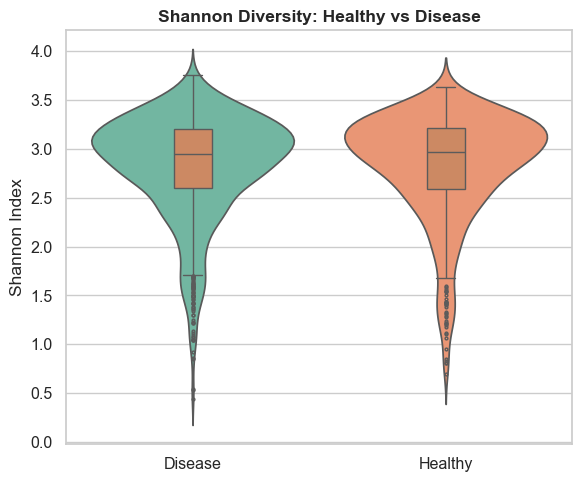

In [8]:
# Visualize Shannon diversity by health status
plt.figure(figsize=(6,5))
sns.violinplot(x='health_status', y='shannon', data=alpha, inner=None, palette='Set2')
sns.boxplot(x='health_status', y='shannon', data=alpha, width=0.15,
            showcaps=True, boxprops={'zorder':2}, fliersize=2)
plt.title("Shannon Diversity: Healthy vs Disease", fontweight='bold')
plt.ylabel("Shannon Index")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [9]:
# Statistical test
healthy = alpha.loc[alpha['health_status'] == 'Healthy', 'shannon']
disease = alpha.loc[alpha['health_status'] == 'Disease', 'shannon']

u_stat, p_val = mannwhitneyu(healthy, disease, alternative='two-sided')
print(f"\nMann–Whitney U test (Shannon, Healthy vs Disease):")
print(f"  p-value: {p_val:.3e}")
print(f"  U-statistic: {u_stat}")
print(f"  Healthy mean: {healthy.mean():.3f}")
print(f"  Disease mean: {disease.mean():.3f}")



Mann–Whitney U test (Shannon, Healthy vs Disease):
  p-value: 6.539e-01
  U-statistic: 386510.0
  Healthy mean: 2.824
  Disease mean: 2.825


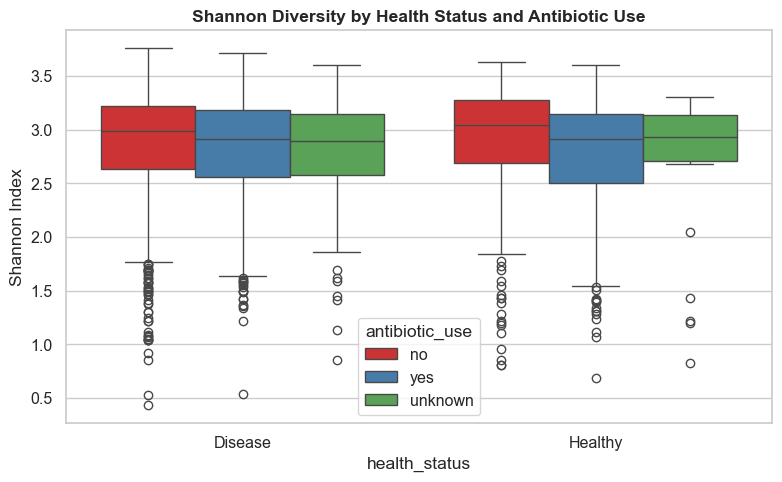

In [10]:
# Shannon diversity by health status & antibiotic use
plt.figure(figsize=(8,5))
sns.boxplot(x='health_status', y='shannon', hue='antibiotic_use',
            data=alpha, palette='Set1')
plt.title("Shannon Diversity by Health Status and Antibiotic Use", fontweight='bold')
plt.ylabel("Shannon Index")
plt.tight_layout()
plt.show()


In [11]:
# Test within antibiotic groups
print("\nStratified analysis by antibiotic use:")
for abx in ['yes', 'no']:
    sub = alpha[alpha['antibiotic_use'] == abx]
    if len(sub['health_status'].unique()) == 2:
        h = sub.loc[sub['health_status'] == 'Healthy', 'shannon']
        d = sub.loc[sub['health_status'] == 'Disease', 'shannon']
        if len(h) > 0 and len(d) > 0:
            u, p = mannwhitneyu(h, d, alternative='two-sided')
            print(f"  Antibiotic={abx}: p={p:.3e}, n_Healthy={len(h)}, n_Disease={len(d)}")

# Save alpha diversity results
alpha.to_csv(os.path.join(TABLES, "alpha_diversity.csv"))



Stratified analysis by antibiotic use:
  Antibiotic=yes: p=3.376e-01, n_Healthy=297, n_Disease=486
  Antibiotic=no: p=8.942e-02, n_Healthy=319, n_Disease=625


# 4. CLR Transformation

In [12]:
def clr_transform(df, pseudo=1e-6):
    """
    Centered log-ratio (CLR) transformation for compositional data.
    Appropriate for microbiome data analysis.
    """
    X = df.values + pseudo
    logX = np.log(X)
    gm = logX.mean(axis=1, keepdims=True)  # Geometric mean per sample
    clr = logX - gm
    return pd.DataFrame(clr, index=df.index, columns=df.columns)

ab_clr = clr_transform(ab_rel, pseudo=1e-6)

print("\nCLR transformation complete")
print(f"  CLR shape: {ab_clr.shape}")
print(f"  CLR per-sample mean (should be ~0): {ab_clr.mean(axis=1).mean():.6f}")

# Save CLR-transformed data
ab_clr.to_csv(os.path.join(TABLES, "abundance_clr.csv"))
print(f"  Saved to: {TABLES}/abundance_clr.csv")



CLR transformation complete
  CLR shape: (1831, 362)
  CLR per-sample mean (should be ~0): 0.000000


  Saved to: data/results_EDA/tables/abundance_clr.csv


# 5. Beta Diversity

In [13]:
# PCA on CLR-transformed data (captures Aitchison distance structure)
pca = PCA(n_components=10, random_state=2025)
pca.fit(ab_clr.values)

# Get PC coordinates
pcs = pd.DataFrame(
    pca.transform(ab_clr.values),
    index=ab_clr.index,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Merge with metadata
pcs_meta = pcs.join(meta[['health_status', 'antibiotic_use']])

# Print variance explained
explained_var = pca.explained_variance_ratio_
print("\nPCA variance explained:")
for i in range(min(5, len(explained_var))):
    print(f"  PC{i+1}: {explained_var[i]*100:.2f}%")
print(f"  Cumulative (PC1-3): {explained_var[:3].sum()*100:.2f}%")



PCA variance explained:
  PC1: 8.62%
  PC2: 4.55%
  PC3: 3.33%
  PC4: 2.55%
  PC5: 2.07%
  Cumulative (PC1-3): 16.49%


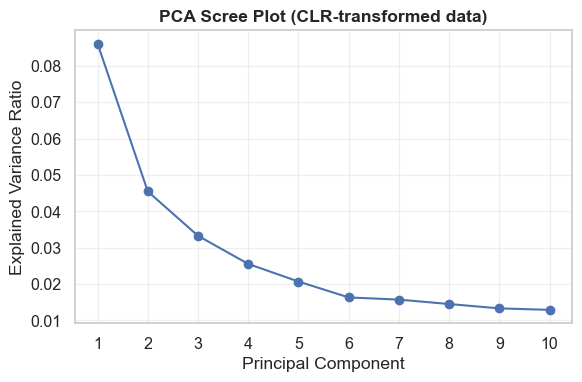

In [14]:
# Scree plot
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot (CLR-transformed data)", fontweight='bold')
plt.xticks(np.arange(1, len(explained_var)+1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


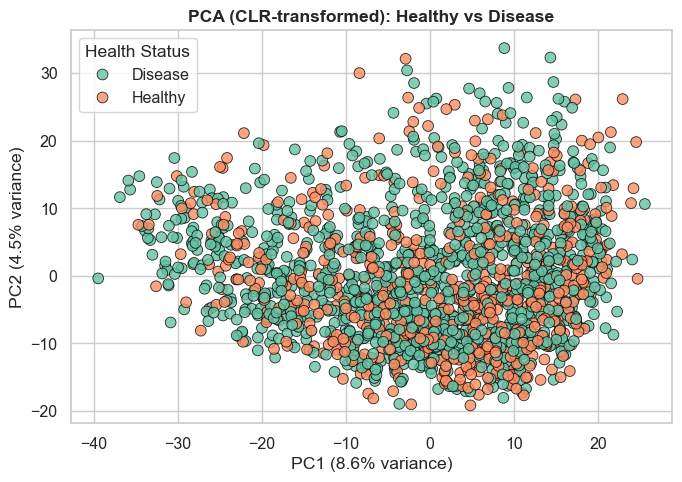

In [15]:
# PCA plot colored by health status
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=pcs_meta, x='PC1', y='PC2',
    hue='health_status', palette='Set2',
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCA (CLR-transformed): Healthy vs Disease", fontweight='bold')
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}% variance)")
plt.legend(title="Health Status")
plt.tight_layout()
plt.show()


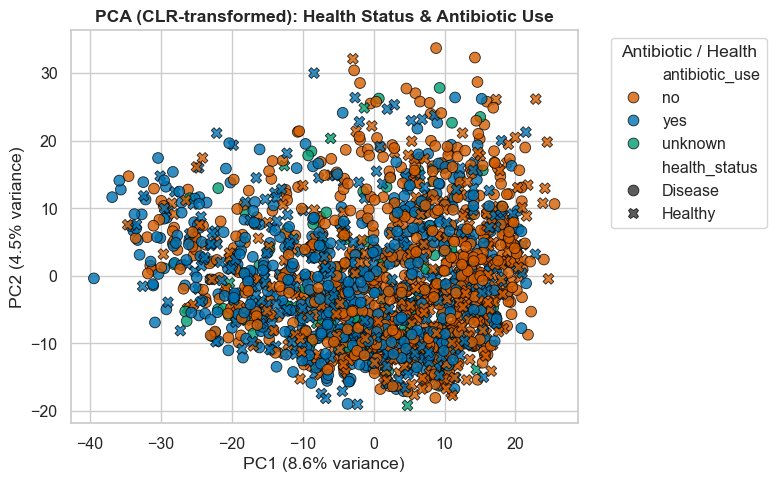

In [16]:
# PCA colored by health status and antibiotic use
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=pcs_meta, x='PC1', y='PC2',
    hue='antibiotic_use', style='health_status',
    palette={'no':'#D55E00', 'yes':'#0072B2', 'unknown':'#009E73'},
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCA (CLR-transformed): Health Status & Antibiotic Use", fontweight='bold')
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}% variance)")
plt.legend(title="Antibiotic / Health", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pca_clr_health_antibiotic.png"), dpi=300, bbox_inches='tight')
plt.show()

# Save PCA results
pcs_meta.to_csv(os.path.join(TABLES, "pca_coordinates.csv"))


In [17]:
# PCoA via eigen-decomposition
def pcoa_from_distance(D, k=2):
    """
    Classical metric MDS (PCoA) from a precomputed distance matrix D.
    Returns coordinates (N x k) and explained variance ratios.
    """
    # Double-centering
    D2 = D ** 2
    n = D.shape[0]
    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * J @ D2 @ J

    # Eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    # Sort descending
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Keep only positive eigenvalues
    pos = eigvals > 0
    eigvals_pos = eigvals[pos]
    eigvecs_pos = eigvecs[:, pos]

    # Coordinates
    coords = eigvecs_pos[:, :k] * np.sqrt(eigvals_pos[:k])

    # Variance explained (only positive eigvals make sense)
    var_exp = eigvals_pos / eigvals_pos.sum()
    var_ratio = var_exp[:k]
    return coords, var_ratio


In [18]:
## 1) BRAY–CURTIS distance + PCoA

# Compute Bray–Curtis distance on relative abundance (samples x taxa)
bc_dist = pdist(ab_rel.values, metric='braycurtis')
bc_DM = squareform(bc_dist)  # (N x N)

# PCoA coordinates
bc_coords, bc_var = pcoa_from_distance(bc_DM, k=2)

# Build a plotting frame with metadata
bc_df = pd.DataFrame(bc_coords, index=ab_rel.index, columns=['PCo1', 'PCo2'])
bc_df = bc_df.join(meta[['health_status', 'antibiotic_use', 'treatment']])

# Save distance matrix and coordinates
pd.DataFrame(bc_DM, index=ab_rel.index, columns=ab_rel.index)\
  .to_csv(os.path.join(TABLES, "beta_braycurtis_distance_matrix.csv"))
bc_df.to_csv(os.path.join(TABLES, "beta_braycurtis_pcoa_coords.csv"))

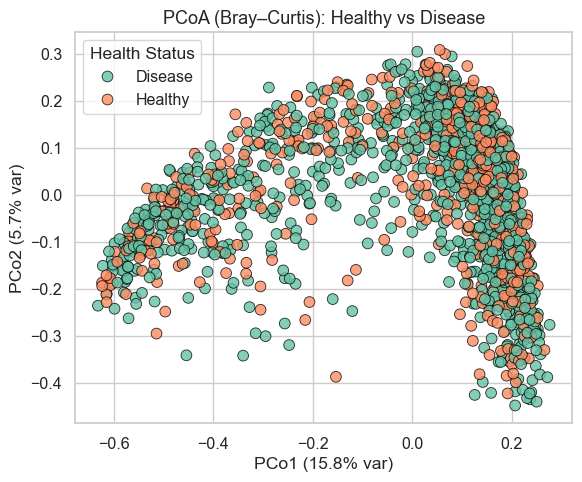

In [19]:
# PCoA plot colored by Health Status
plt.figure(figsize=(6,5))
sns.set(style="whitegrid", font_scale=1.05)
sns.scatterplot(
    data=bc_df, x='PCo1', y='PCo2',
    hue='health_status', palette='Set2',
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCoA (Bray–Curtis): Healthy vs Disease", fontsize=13)
plt.xlabel(f"PCo1 ({bc_var[0]*100:.1f}% var)")
plt.ylabel(f"PCo2 ({bc_var[1]*100:.1f}% var)")
plt.legend(title="Health Status", frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pcoa_braycurtis_healthstatus.png"), dpi=300)
plt.show()

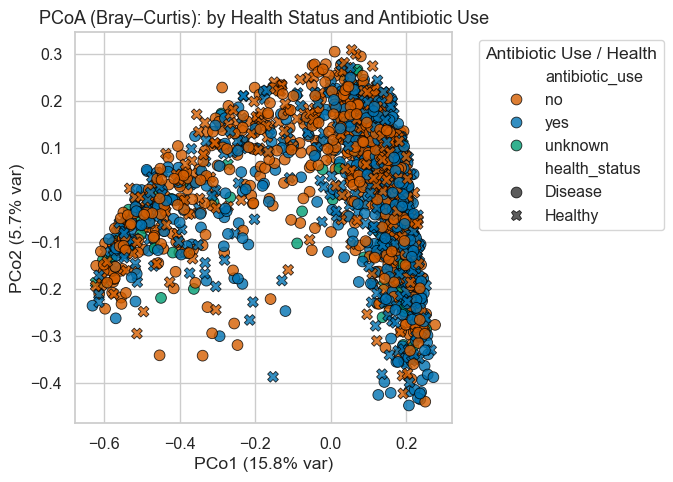

In [20]:
# Plot: PCoA colored by Antibiotic Use
plt.figure(figsize=(7,5))
sns.set(style="whitegrid", font_scale=1.05)
sns.scatterplot(
    data=bc_df, x='PCo1', y='PCo2',
    hue='antibiotic_use', style='health_status',
    palette={'no':'#D55E00','yes':'#0072B2','unknown':'#009E73'},
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCoA (Bray–Curtis): by Health Status and Antibiotic Use", fontsize=13)
plt.xlabel(f"PCo1 ({bc_var[0]*100:.1f}% var)")
plt.ylabel(f"PCo2 ({bc_var[1]*100:.1f}% var)")
plt.legend(title="Antibiotic Use / Health", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pcoa_braycurtis_health_antibiotic.png"), dpi=300, bbox_inches='tight')
plt.show()


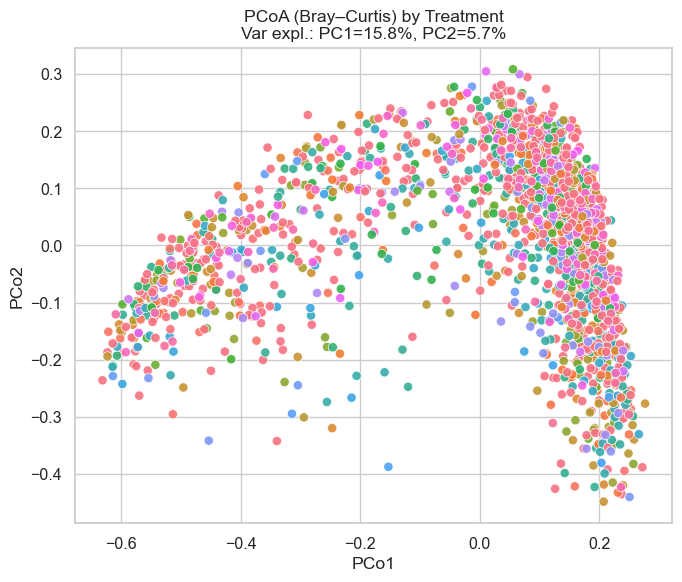

In [21]:
# PCoA colored by Treatment
if meta['treatment'].notna().sum() > 0 and meta['treatment'].nunique() > 1:
    plt.figure(figsize=(7,6))
    sns.scatterplot(
        data=bc_df, x='PCo1', y='PCo2',
        hue='treatment', s=45, edgecolor='white', alpha=0.9, legend=False
    )
    plt.title(f"PCoA (Bray–Curtis) by Treatment\nVar expl.: PC1={bc_var[0]:.1%}, PC2={bc_var[1]:.1%}")
    plt.xlabel("PCo1")
    plt.ylabel("PCo2")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS, "pcoa_braycurtis_by_treatment.png"), dpi=300, bbox_inches='tight')
    plt.show()



# 6. PERMANOVA Analysis

In [22]:
# Compute Aitchison distance (Euclidean distance in CLR space)
clr_dist = pdist(ab_clr.values, metric='euclidean')
clr_DM = squareform(clr_dist)
dm_clr = DistanceMatrix(clr_DM, ids=list(ab_clr.index))

# Save distance matrix
pd.DataFrame(clr_DM, index=ab_clr.index, columns=ab_clr.index).to_csv(
    os.path.join(TABLES, "aitchison_distance_matrix.csv")
)


In [23]:
# PERMANOVA: Health status
res_health = permanova(dm_clr, pcs_meta['health_status'], permutations=999)
print("\nPERMANOVA (Aitchison distance) ~ health_status")
print(res_health)



PERMANOVA (Aitchison distance) ~ health_status
method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1831
number of groups                  2
test statistic              5.50208
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


In [24]:
# PERMANOVA: Antibiotic use
res_abx = permanova(dm_clr, pcs_meta['antibiotic_use'], permutations=999)
print("\nPERMANOVA (Aitchison distance) ~ antibiotic_use")
print(res_abx)

# Save PERMANOVA results
with open(os.path.join(TABLES, "permanova_results.txt"), "w") as f:
    f.write("PERMANOVA (Aitchison distance) ~ health_status\n")
    f.write(str(res_health) + "\n\n")
    f.write("PERMANOVA (Aitchison distance) ~ antibiotic_use\n")
    f.write(str(res_abx) + "\n")



PERMANOVA (Aitchison distance) ~ antibiotic_use
method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1831
number of groups                  3
test statistic             5.424421
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


# 7. Create Disease Groups for Downstream Analysis

In [25]:
def create_disease_groups(meta):
    """
    Create biologically meaningful disease groupings.
    Maps study conditions to metabolic, cardiovascular, or control.
    """
    manual_map = {
        'IGT': 'metabolic',           # Impaired Glucose Tolerance
        'T2D': 'metabolic',            # Type 2 Diabetes
        'control': 'control',
        'CAD': 'cardiovascular',       # Coronary Artery Disease
        'HF': 'cardiovascular'         # Heart Failure
    }

    meta['disease_group'] = meta['study_condition'].map(manual_map)

    print("\nDisease group distribution:")
    print(meta['disease_group'].value_counts())
    print(f"\nPercentage breakdown:")
    for group, count in meta['disease_group'].value_counts().items():
        pct = count / len(meta) * 100
        print(f"  {group}: {pct:.1f}%")

    return meta

meta = create_disease_groups(meta)

# Save updated metadata with disease groups
meta.to_csv(os.path.join(TABLES, "metadata_with_disease_groups.csv"))



Disease group distribution:
disease_group
metabolic         825
control           642
cardiovascular    364
Name: count, dtype: int64

Percentage breakdown:
  metabolic: 45.1%
  control: 35.1%
  cardiovascular: 19.9%


# 8. Taxonomic Aggregation Analysis

In [26]:
def aggregate_by_taxonomy(ab_rel, taxa_meta, level='phylum'):
    """
    Aggregate species-level abundances to higher taxonomic levels.

    Parameters:
    -----------
    ab_rel : DataFrame (samples × species)
    taxa_meta : DataFrame with taxonomic information
    level : str - 'phylum', 'class', 'order', 'family', or 'genus'
    """
    # Align
    common_taxa = ab_rel.columns.intersection(taxa_meta.index)
    ab_subset = ab_rel[common_taxa]
    taxa_subset = taxa_meta.loc[common_taxa]

    # Group and sum
    level_groups = taxa_subset.groupby(level).groups
    ab_aggregated = pd.DataFrame(index=ab_subset.index)

    for taxon, species_list in level_groups.items():
        if pd.notna(taxon):  # Skip unclassified
            ab_aggregated[taxon] = ab_subset[species_list].sum(axis=1)

    coverage = ab_aggregated.sum(axis=1).mean() * 100
    print(f"\n{level.capitalize()}-level aggregation:")
    print(f"  Species: {len(common_taxa)} → {level.capitalize()}: {ab_aggregated.shape[1]}")
    print(f"  Coverage: {coverage:.1f}% of reads")

    return ab_aggregated


In [27]:
# Aggregate at different taxonomic levels
for level in ['phylum', 'family', 'genus']:
    ab_agg = aggregate_by_taxonomy(ab_rel, taxa_meta, level=level)

    # Save aggregated table
    ab_agg.to_csv(os.path.join(TABLES, f"abundance_{level}_level.csv"))



Phylum-level aggregation:
  Species: 362 → Phylum: 12
  Coverage: 100.0% of reads

Family-level aggregation:
  Species: 362 → Family: 48
  Coverage: 98.2% of reads

Genus-level aggregation:
  Species: 362 → Genus: 123
  Coverage: 95.1% of reads


# 9. Differential Abundance Analysis

In [28]:
def analyze_taxonomic_signatures(ab_rel, taxa_meta, meta, level='family'):
    """
    Identify taxa differentially abundant between disease groups and controls.
    Uses Mann-Whitney U test with FDR correction.
    """
    print(f"\n{'='*60}")
    print(f"DIFFERENTIAL ABUNDANCE ANALYSIS - {level.upper()} LEVEL")
    print('='*60)

    # Aggregate to specified level
    ab_agg = aggregate_by_taxonomy(ab_rel, taxa_meta, level=level)

    # Align with metadata
    common_idx = ab_agg.index.intersection(meta.index)
    ab_agg_aligned = ab_agg.loc[common_idx]
    meta_aligned = meta.loc[common_idx]

    results = {}

    for disease_group in ['metabolic', 'cardiovascular']:
        print(f"\n{disease_group.upper()} vs CONTROL")
        print('-'*60)

        disease_samples = meta_aligned['disease_group'] == disease_group
        control_samples = meta_aligned['disease_group'] == 'control'

        pvalues, fold_changes, taxa_names = [], [], []

        for taxon in ab_agg_aligned.columns:
            disease_abund = ab_agg_aligned.loc[disease_samples, taxon]
            control_abund = ab_agg_aligned.loc[control_samples, taxon]

            # Skip sparse taxa
            if (disease_abund > 0).sum() < 5 or (control_abund > 0).sum() < 5:
                continue

            try:
                # Mann-Whitney U test
                stat, pval = stats.mannwhitneyu(disease_abund, control_abund,
                                               alternative='two-sided')

                # Fold change (log2)
                mean_disease = disease_abund.mean() + 1e-10
                mean_control = control_abund.mean() + 1e-10
                fc = np.log2(mean_disease / mean_control)

                pvalues.append(pval)
                fold_changes.append(fc)
                taxa_names.append(taxon)
            except:
                continue

        # FDR correction
        if len(pvalues) > 0:
            reject, pvals_corrected, _, _ = multipletests(pvalues, method='fdr_bh')

            results_df = pd.DataFrame({
                'taxon': taxa_names,
                'log2_FC': fold_changes,
                'pvalue': pvalues,
                'padj': pvals_corrected,
                'significant': reject
            })

            # Sort by absolute fold change
            sig_results = results_df[results_df['significant']].copy()
            sig_results = sig_results.sort_values('log2_FC', key=abs, ascending=False)

            results[disease_group] = sig_results

            print(f"Significant taxa (FDR < 0.05): {sig_results.shape[0]} / {len(pvalues)}")

            if sig_results.shape[0] > 0:
                print(f"\nTop 5 enriched in {disease_group}:")
                top_enriched = sig_results[sig_results['log2_FC'] > 0].head(5)
                for _, row in top_enriched.iterrows():
                    print(f"  {row['taxon']:30s} | FC: {2**row['log2_FC']:6.2f}x | "
                          f"padj: {row['padj']:.2e}")

                print(f"\nTop 5 depleted in {disease_group}:")
                top_depleted = sig_results[sig_results['log2_FC'] < 0].head(5)
                for _, row in top_depleted.iterrows():
                    print(f"  {row['taxon']:30s} | FC: {2**row['log2_FC']:6.2f}x | "
                          f"padj: {row['padj']:.2e}")

            # Save results
            filename = f'differential_abundance_{level}_{disease_group}.csv'
            sig_results.to_csv(os.path.join(TABLES, filename), index=False)

    return results


In [29]:
# Run differential abundance analysis at family level
taxonomic_results = analyze_taxonomic_signatures(ab_rel, taxa_meta, meta, level='family')



DIFFERENTIAL ABUNDANCE ANALYSIS - FAMILY LEVEL



Family-level aggregation:
  Species: 362 → Family: 48
  Coverage: 98.2% of reads

METABOLIC vs CONTROL
------------------------------------------------------------
Significant taxa (FDR < 0.05): 13 / 47

Top 5 enriched in metabolic:
  Synergistaceae                 | FC:   8.86x | padj: 4.41e-04
  Hafniaceae                     | FC:   3.93x | padj: 3.92e-04
  Enterobacteriaceae             | FC:   2.97x | padj: 6.03e-32
  Coprobacillaceae               | FC:   1.50x | padj: 2.36e-04
  Selenomonadaceae               | FC:   1.43x | padj: 3.94e-02

Top 5 depleted in metabolic:
  Brachyspiraceae                | FC:   0.33x | padj: 2.81e-03
  Clostridiaceae                 | FC:   0.56x | padj: 4.41e-04
  Peptostreptococcaceae          | FC:   0.79x | padj: 1.24e-03
  Barnesiellaceae                | FC:   0.83x | padj: 7.16e-03
  Rikenellaceae                  | FC:   0.84x | padj: 1.52e-03

CARDIOVASCULAR vs CONTROL
------------------------------------------------------------
Signific

In [30]:
# Optional: Run at genus level
taxonomic_results_genus = analyze_taxonomic_signatures(ab_rel, taxa_meta, meta, level='genus')



DIFFERENTIAL ABUNDANCE ANALYSIS - GENUS LEVEL

Genus-level aggregation:
  Species: 362 → Genus: 123
  Coverage: 95.1% of reads

METABOLIC vs CONTROL
------------------------------------------------------------
Significant taxa (FDR < 0.05): 40 / 122

Top 5 enriched in metabolic:
  Pyramidobacter                 | FC:  61.13x | padj: 9.54e-05
  Hafnia                         | FC:   3.93x | padj: 1.70e-04
  Cloacibacillus                 | FC:   3.91x | padj: 1.54e-03
  Hungatella                     | FC:   3.65x | padj: 1.80e-06
  Limosilactobacillus            | FC:   3.43x | padj: 9.67e-06

Top 5 depleted in metabolic:
  Brachyspira                    | FC:   0.33x | padj: 2.50e-03
  Propionibacterium              | FC:   0.34x | padj: 4.66e-02
  Methanosphaera                 | FC:   0.47x | padj: 2.42e-02
  Clostridium                    | FC:   0.52x | padj: 7.96e-06
  Butyrivibrio                   | FC:   0.63x | padj: 1.10e-04

CARDIOVASCULAR vs CONTROL
----------------------

Significant taxa (FDR < 0.05): 19 / 119

Top 5 enriched in cardiovascular:
  Limosilactobacillus            | FC:   6.69x | padj: 4.96e-04
  Escherichia                    | FC:   3.52x | padj: 3.12e-02
  Eisenbergiella                 | FC:   3.51x | padj: 1.25e-04
  Hungatella                     | FC:   2.29x | padj: 3.10e-03
  Rothia                         | FC:   2.27x | padj: 1.56e-02

Top 5 depleted in cardiovascular:
  Lactococcus                    | FC:   0.31x | padj: 1.21e-02
  Parasutterella                 | FC:   0.59x | padj: 4.96e-04
  Turicimonas                    | FC:   0.63x | padj: 4.96e-04
  Bilophila                      | FC:   0.77x | padj: 2.80e-02
  Flavonifractor                 | FC:   0.79x | padj: 4.18e-02


# 10. Species Specific Analysis

## Read data

In [31]:
abundance_clean = pd.read_csv('data/MetaCardis2020_relative_abundance.csv', index_col=0).T
abundance_clean.head()

taxa,Bacteroides uniformis,Phocaeicola dorei,Alistipes finegoldii,Phocaeicola vulgatus,Eubacterium sp. CAG:180,[Eubacterium] siraeum,Ruminococcus bromii,Faecalibacterium prausnitzii,Alistipes inops,Bacteroides caccae,...,Selenomonas sp. oral taxon 920,Prevotella dentalis,Dysgonomonas sp. 37-18,Criibacterium bergeronii,Sneathia vaginalis,Mageeibacillus indolicus,Dialister micraerophilus,Tissierellia bacterium KA00581,Anaerococcus lactolyticus,Actinomyces naeslundii
M0x10MCx1134,18.68909,10.88477,8.14016,7.69579,5.24825,5.07696,5.02719,4.30983,4.13960,3.87180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M0x10MCx1135,0.47634,0.12509,0.11658,0.06780,5.09389,0.04229,0.00000,5.53411,0.00000,0.50499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M0x10MCx1138,1.69175,19.99088,0.31639,1.37651,0.00000,0.00000,0.00000,2.18830,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M0x10MCx1140,8.54740,8.29615,0.00000,2.42549,0.00000,1.19415,0.00000,8.54110,10.29545,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M0x10MCx1143,11.01829,28.54958,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.20877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
sample_metadata = pd.read_csv('data/MetaCardis2020_sample_metadata.csv', index_col=0)
sample_metadata.head()



,study_name,subject_id,body_site,antibiotics_current_use,study_condition,disease,age_category,gender,country,non_westernized,...,BMI,treatment,location,disease_subtype,triglycerides,hba1c,smoke,bristol_score,hsCRP,LDL
M0x10MCx1134,MetaCardis_2020_a,M0x10MCx1134,stool,no,IGT,IGT;MS,adult,female,FRA,no,...,44.365888,antihta;thiazidique;at2_inhib,Paris,NaN,97.940706,6.0,no,1.0,1.3,140.673726
M0x10MCx1135,MetaCardis_2020_a,M0x10MCx1135,stool,no,T2D,T2D,adult,male,FRA,no,...,27.719670,antidiab;su;metformin;dppiv;insulin,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN
M0x10MCx1138,MetaCardis_2020_a,M0x10MCx1138,stool,yes,T2D,T2D,adult,male,FRA,no,...,38.221055,antidiab;su;metformin,Paris,NaN,NaN,NaN,1.0,NaN,NaN,NaN
M0x10MCx1140,MetaCardis_2020_a,M0x10MCx1140,stool,NaN,control,MS,adult,female,FRA,no,...,36.283006,antihta;thiazidique;at2_inhib;ca2_cbl,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN
M0x10MCx1143,MetaCardis_2020_a,M0x10MCx1143,stool,yes,T2D,T2D,senior,female,FRA,no,...,39.817729,antihta;antidiab;thiazidique;at2_inhib;metformin,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN


In [33]:
taxa_meta = pd.read_csv('data/MetaCardis2020_taxa_metadata.csv', index_col=0)
taxa_meta.head()

,superkingdom,phylum,class,order,family,genus,species
Bacteroides uniformis,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides uniformis
Phocaeicola dorei,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola dorei
Alistipes finegoldii,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,Alistipes finegoldii
Phocaeicola vulgatus,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola vulgatus
Eubacterium sp. CAG:180,Bacteria,Firmicutes,Clostridia,Eubacteriales,Eubacteriaceae,Eubacterium,Eubacterium sp. CAG:180


## Check the abundance of the bacteria based on condition and antibiotic use

In [34]:
counts_df = pd.merge(sample_metadata, abundance_clean, right_index=True, left_index=True)
counts_df.value_counts(['antibiotics_current_use','study_condition'])

antibiotics_current_use  study_condition
no                       control            319
                         T2D                306
yes                      control            297
                         T2D                209
no                       CAD                163
yes                      IGT                138
no                       IGT                113
yes                      CAD                 89
                         HF                  50
no                       HF                  43
Name: count, dtype: int64

In [35]:
counts_df['antibiotics_current_use'].value_counts()


antibiotics_current_use
no     944
yes    783
Name: count, dtype: int64

In [36]:
counts_df['study_condition'].value_counts()

study_condition
control    642
T2D        550
IGT        275
CAD        269
HF          95
Name: count, dtype: int64

## Mann–Whitney U test

In [37]:
def test_diff_abundance(df, group_col, species):
    group1 = df[df[group_col] == 'Yes'][species]
    group2 = df[df[group_col] == 'No'][species]
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    return p

In [38]:
results = pd.DataFrame({
    'species': abundance_clean.columns,
    'p_value': [test_diff_abundance(counts_df, 'antibiotics_current_use', sp) for sp in abundance_clean.columns]
})
results['p_adj'] = results['p_value'] * len(results)  # Bonferroni correction
results.sort_values('p_adj')

,species,p_value,p_adj
0,Bacteroides uniformis,NaN,NaN
1,Phocaeicola dorei,NaN,NaN
2,Alistipes finegoldii,NaN,NaN
3,Phocaeicola vulgatus,NaN,NaN
4,Eubacterium sp. CAG:180,NaN,NaN
...,...,...,...
692,Mageeibacillus indolicus,NaN,NaN
693,Dialister micraerophilus,NaN,NaN
694,Tissierellia bacterium KA00581,NaN,NaN
695,Anaerococcus lactolyticus,NaN,NaN


In [39]:
df = counts_df.dropna(subset=['antibiotics_current_use']).copy()

# unique groups
groups = df['antibiotics_current_use'].unique()
print("Groups:", groups)

# must have 2 groups
if len(groups) != 2:
    raise ValueError(f"Expected 2 groups, got {len(groups)}: {groups}")

group1, group2 = groups


Groups: ['no' 'yes']


In [40]:
results = []

# Iterate through each bacterial species column
for species in abundance_clean.columns:
    vals1 = df[df['antibiotics_current_use'] == group1][species]
    vals2 = df[df['antibiotics_current_use'] == group2][species]

    # Mann–Whitney U test
    stat, pval = mannwhitneyu(vals1, vals2, alternative='two-sided')

    # Compute effect size (optional)
    n1, n2 = len(vals1), len(vals2)
    z = (stat - (n1 * n2 / 2)) / np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    effect_size = abs(z) / np.sqrt(n1 + n2)

    results.append({
        'species': species,
        'p_value': pval,
        'effect_size': effect_size
    })

results_df = pd.DataFrame(results)

# Apply Benjamini-Hochberg (FDR) correction for multiple testing
results_df = results_df.sort_values('p_value')
m = len(results_df)
results_df['p_adj'] = results_df['p_value'] * m / (np.arange(1, m + 1))
results_df['p_adj'] = results_df['p_adj'].clip(upper=1)

results_df

,species,p_value,effect_size,p_adj
147,[Ruminococcus] gnavus,3.045430e-13,0.153264,2.122665e-10
31,Flavonifractor plautii,8.080530e-13,0.171921,2.816065e-10
225,Coprococcus eutactus,1.854211e-11,0.136059,4.307950e-09
41,Firmicutes bacterium CAG:110,2.433791e-11,0.148834,4.240881e-09
76,Firmicutes bacterium CAG:95,7.486746e-11,0.134463,1.043652e-08
...,...,...,...,...
550,Peptoniphilus duerdenii,1.000000e+00,0.000000,1.000000e+00
517,Leptotrichia wadei,1.000000e+00,0.000000,1.000000e+00
585,Fusobacterium naviforme,1.000000e+00,0.000000,1.000000e+00
308,Prevotella sp. S7-1-8,1.000000e+00,0.000000,1.000000e+00


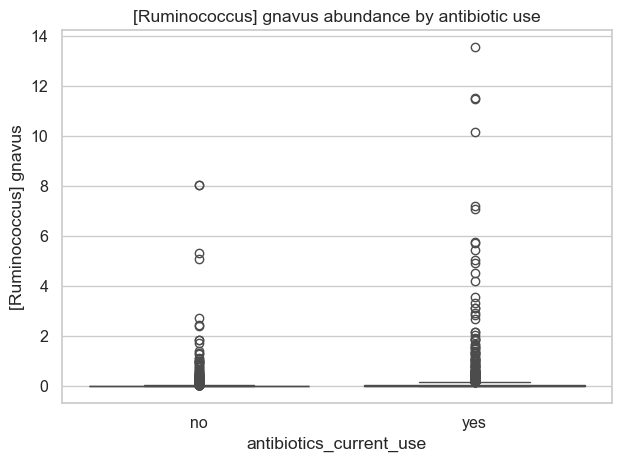

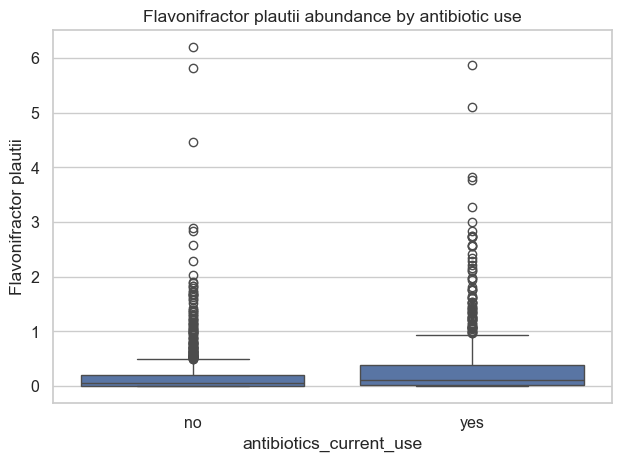

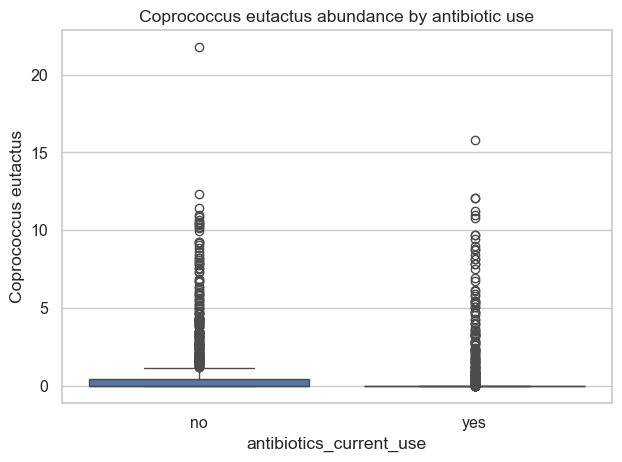

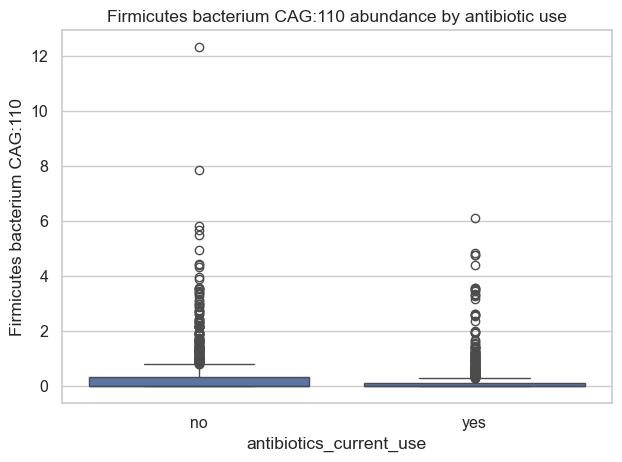

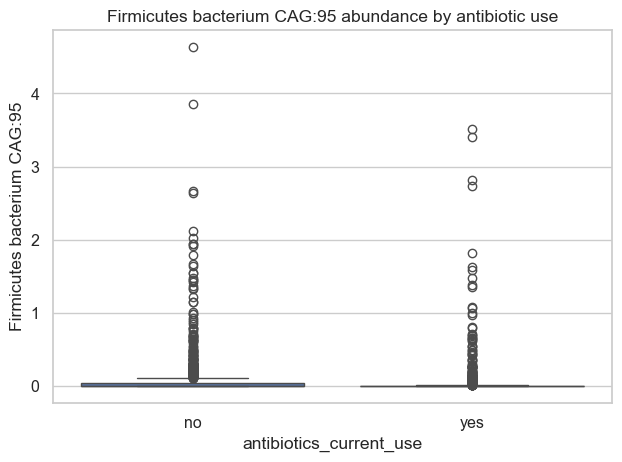

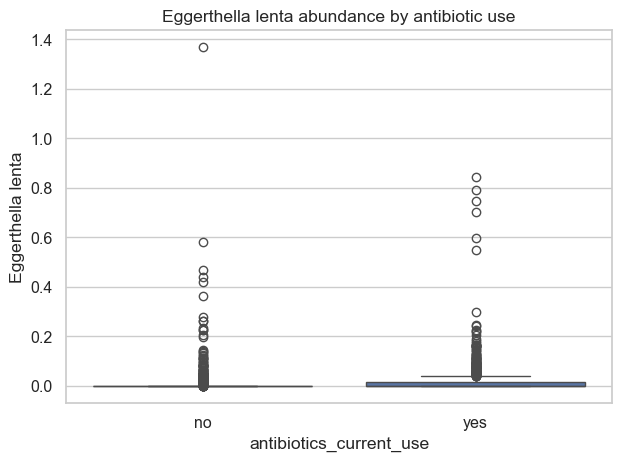

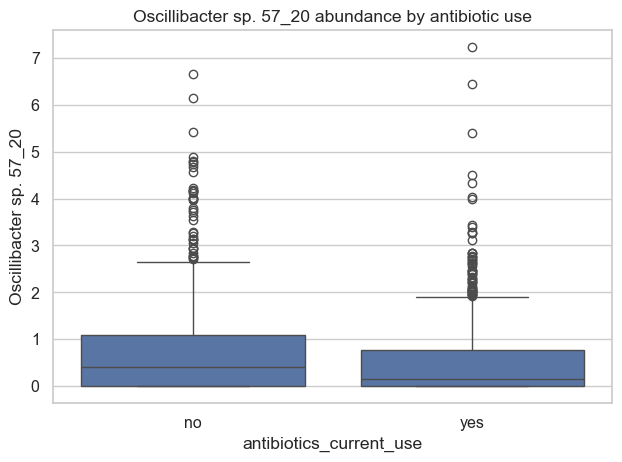

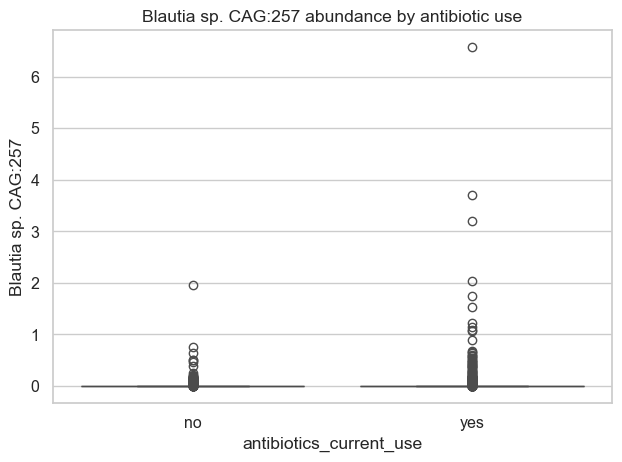

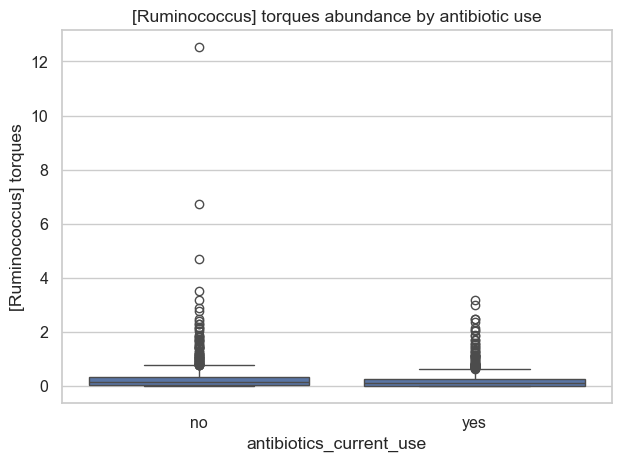

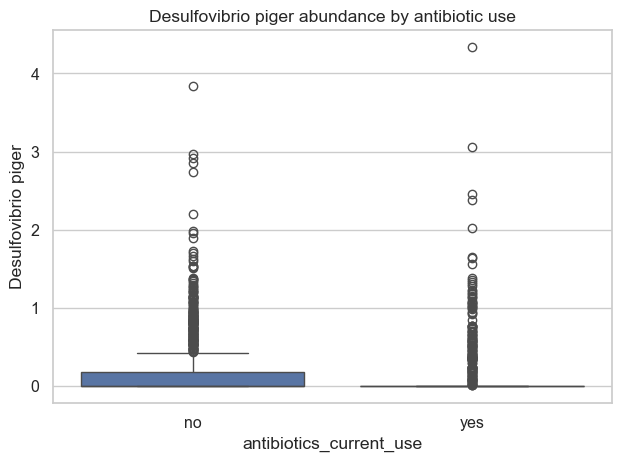

In [41]:
top_species = results_df.head(10)['species']
for sp in top_species:
    sns.boxplot(
        data=df,
        x='antibiotics_current_use',
        y=sp
    )
    plt.title(f'{sp} abundance by antibiotic use')
    plt.tight_layout()
    plt.show()

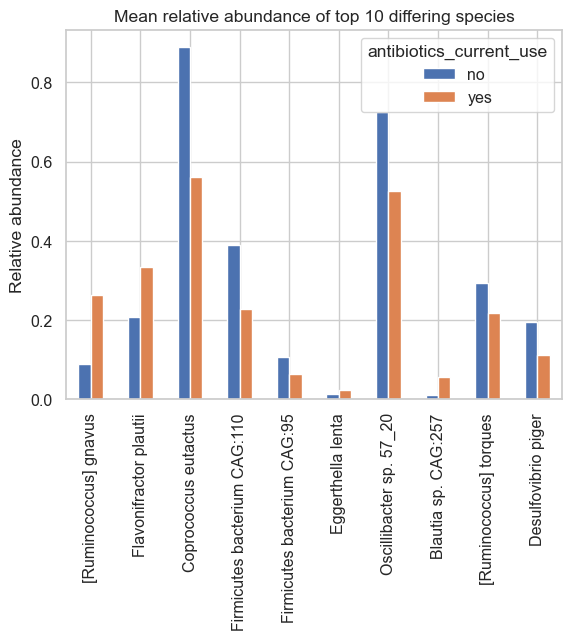

In [42]:
mean_abund = df.groupby('antibiotics_current_use')[top_species].mean().T
mean_abund.plot(kind='bar')
plt.title('Mean relative abundance of top 10 differing species')
plt.ylabel('Relative abundance')
plt.show()


In [43]:
# Select top N significant species
top_species = results_df.sort_values('p_adj').head(20)['species'].tolist()

# Subset your data for these taxa only
subset = counts_df[top_species].copy()

# Add antibiotic use label for visualization
subset['antibiotics_current_use'] = counts_df['antibiotics_current_use']

## Kruskal–Wallis test for differences by study condition

In [44]:
# Drop rows missing study_condition
df_cond = counts_df.dropna(subset=['study_condition']).copy()
print(df_cond.shape)


(1831, 722)


In [45]:
results_condition = []

for sp in abundance_clean.columns:
    # Group values by each condition
    groups = [df_cond[df_cond['study_condition'] == cond][sp]
              for cond in df_cond['study_condition'].unique()]

    # Skip if all zeros
    if all(g.sum() == 0 for g in groups):
        continue

    stat, pval = kruskal(*groups)
    results_condition.append({'species': sp, 'p_value': pval})

In [46]:
results_condition = pd.DataFrame(results_condition)
results_condition['p_adj'] = results_condition['p_value'] * len(results_condition) / (np.arange(1, len(results_condition)+1))
results_condition['p_adj'] = results_condition['p_adj'].clip(upper=1)
results_condition = results_condition.sort_values('p_adj')

results_condition


,species,p_value,p_adj
43,Escherichia coli,8.586275e-53,1.360144e-51
142,Enterocloster clostridioformis,1.473670e-17,7.182852e-17
168,Intestinibacter bartlettii,4.979796e-17,2.053798e-16
66,Clostridium sp. CAG:167,2.653612e-17,2.760548e-16
225,Coprococcus eutactus,5.840627e-15,1.801291e-14
...,...,...,...
357,Prevotella salivae,5.989843e-01,1.000000e+00
356,Streptococcus sp. F0442,8.021805e-01,1.000000e+00
355,Lachnospiraceae bacterium oral taxon 096,6.030029e-01,1.000000e+00
368,Oribacterium parvum,8.113457e-01,1.000000e+00


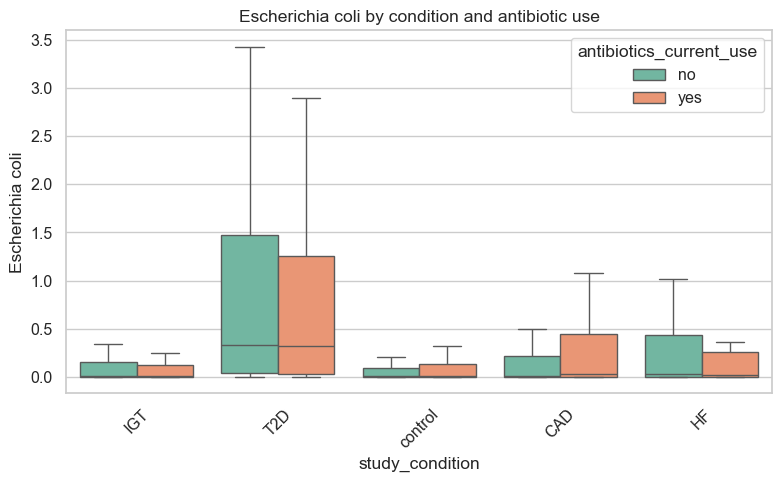

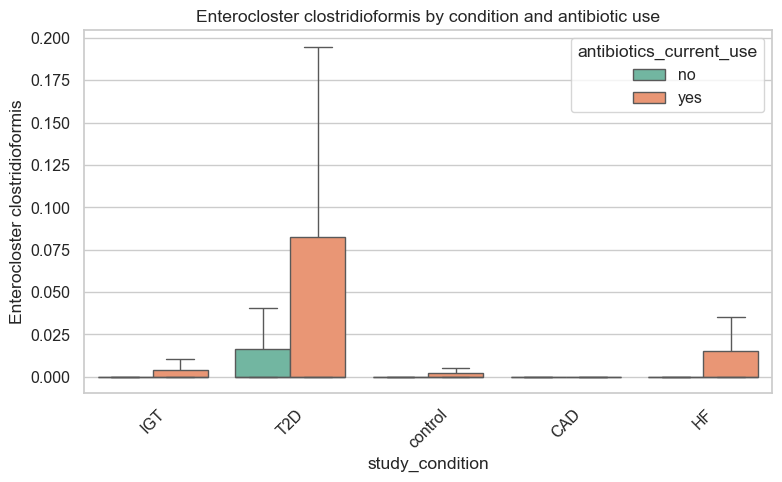

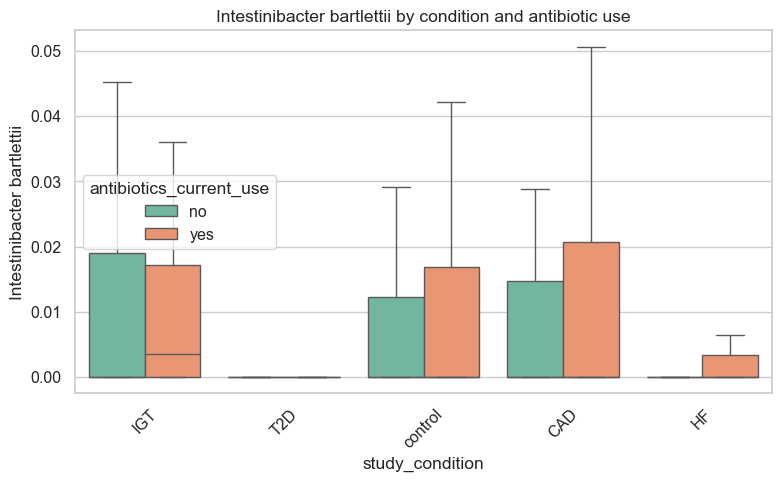

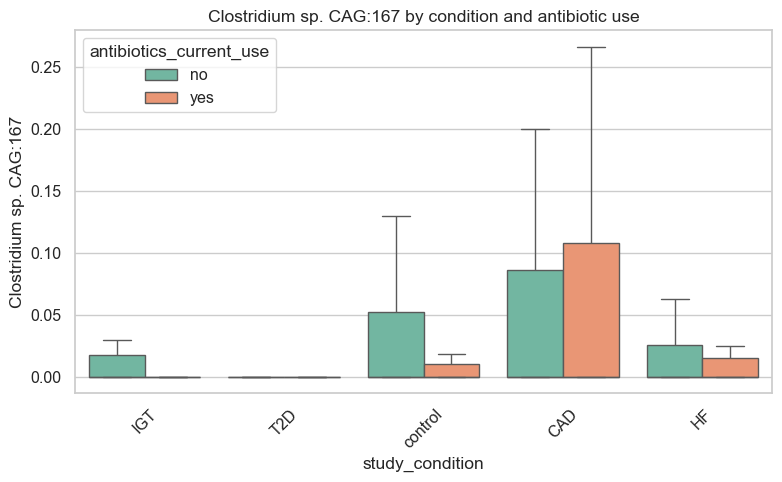

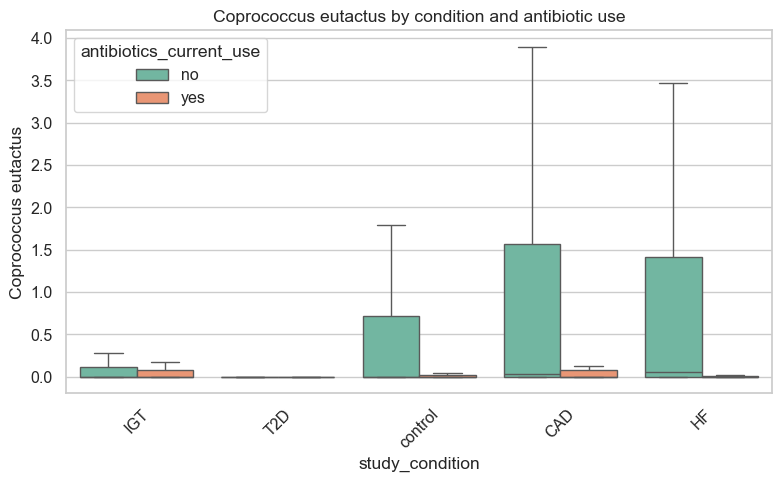

In [47]:
top_species = results_condition.head(5)['species']

for sp in top_species:
    plt.figure(figsize=(8,5))
    sns.boxplot(
        data=counts_df,
        x='study_condition',
        y=sp,
        hue='antibiotics_current_use',
        palette='Set2',
        showfliers=False
    )
    plt.title(f'{sp} by condition and antibiotic use')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Only Disease and Healthy

In [48]:
# Add new column "health_status"
counts_df['health_status'] = counts_df['study_condition'].apply(
    lambda x: 'Healthy' if x.lower() == 'control' else 'Disease'
)

# Check distribution
counts_df['health_status'].value_counts()


health_status
Disease    1189
Healthy     642
Name: count, dtype: int64

In [49]:
# Drop rows missing study_condition
df_cond = counts_df.dropna(subset=['study_condition']).copy()
print(df_cond.shape)


(1831, 723)


In [50]:
results_condition = []

for sp in abundance_clean.columns:
    # Group values by each condition
    groups = [df_cond[df_cond['study_condition'] == cond][sp]
              for cond in df_cond['study_condition'].unique()]

    # Skip if all zeros
    if all(g.sum() == 0 for g in groups):
        continue

    stat, pval = kruskal(*groups)
    results_condition.append({'species': sp, 'p_value': pval})

In [51]:
results_condition = pd.DataFrame(results_condition)
results_condition['p_adj'] = results_condition['p_value'] * len(results_condition) / (np.arange(1, len(results_condition)+1))
results_condition['p_adj'] = results_condition['p_adj'].clip(upper=1)
results_condition = results_condition.sort_values('p_adj')

results_condition


,species,p_value,p_adj
43,Escherichia coli,8.586275e-53,1.360144e-51
142,Enterocloster clostridioformis,1.473670e-17,7.182852e-17
168,Intestinibacter bartlettii,4.979796e-17,2.053798e-16
66,Clostridium sp. CAG:167,2.653612e-17,2.760548e-16
225,Coprococcus eutactus,5.840627e-15,1.801291e-14
...,...,...,...
357,Prevotella salivae,5.989843e-01,1.000000e+00
356,Streptococcus sp. F0442,8.021805e-01,1.000000e+00
355,Lachnospiraceae bacterium oral taxon 096,6.030029e-01,1.000000e+00
368,Oribacterium parvum,8.113457e-01,1.000000e+00


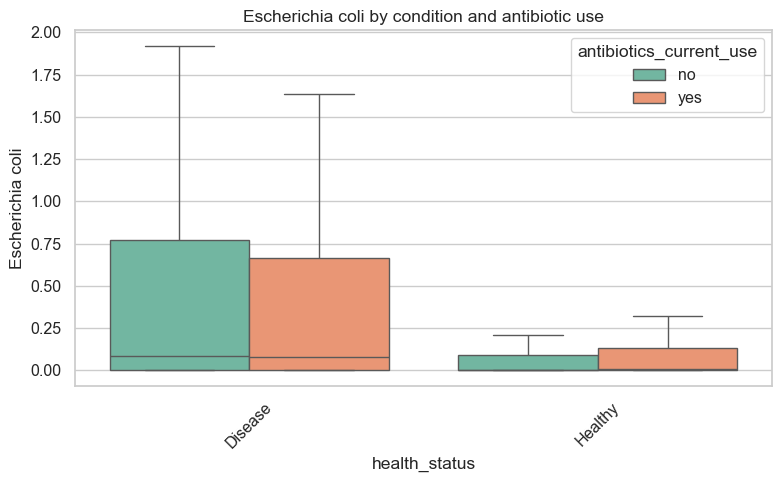

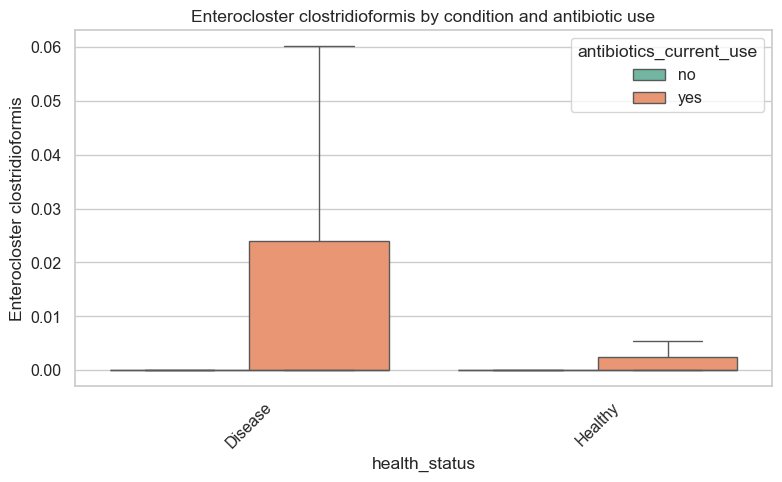

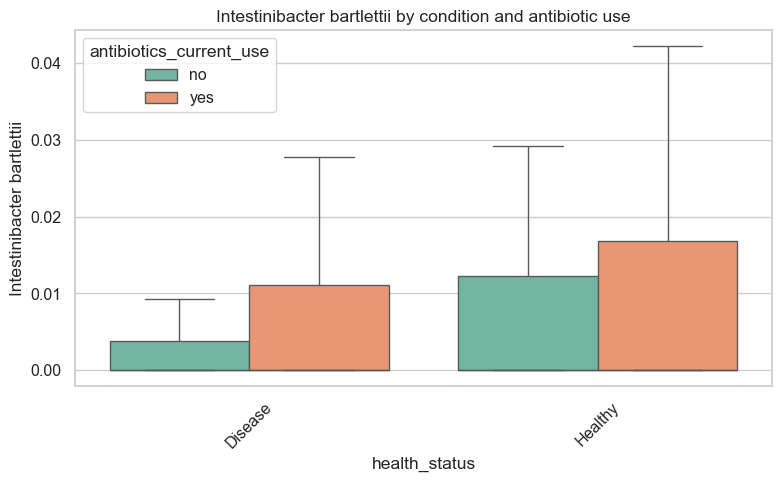

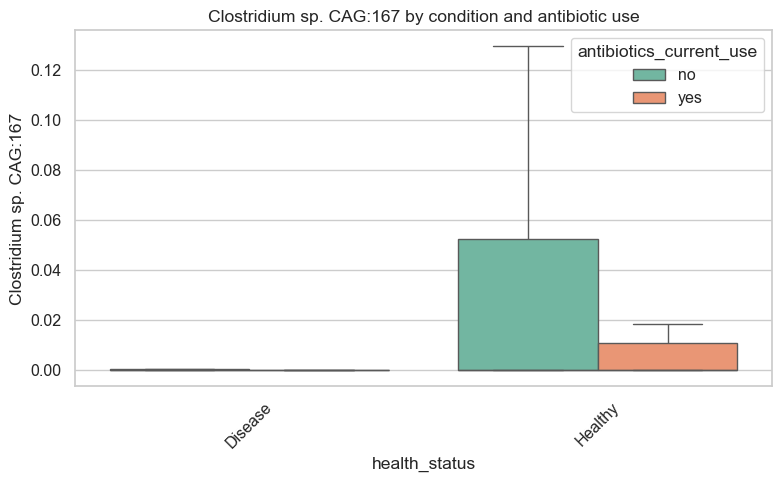

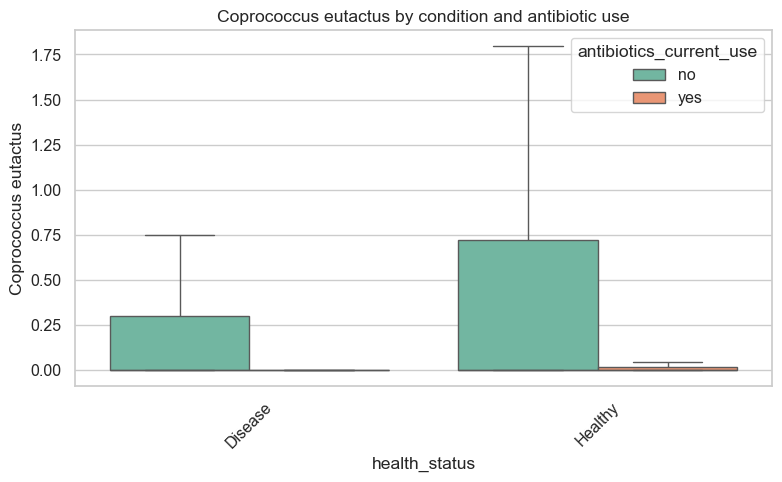

In [52]:
top_species = results_condition.head(5)['species']

for sp in top_species:
    plt.figure(figsize=(8,5))
    sns.boxplot(
        data=counts_df,
        x='health_status',
        y=sp,
        hue='antibiotics_current_use',
        palette='Set2',
        showfliers=False
    )
    plt.title(f'{sp} by condition and antibiotic use')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# 11. Taxonomic Aggregation Analysis


In [53]:
def aggregate_by_taxonomy(ab_rel, taxa_meta, level='phylum'):
    """
    Aggregate species-level abundances to higher taxonomic levels.

    Parameters:
    -----------
    ab_rel : DataFrame
        Relative abundances (samples x species)
    taxa_meta : DataFrame
        Taxonomic metadata for each species
    level : str
        Taxonomic level: 'phylum', 'class', 'order', 'family', 'genus'

    Returns:
    --------
    ab_aggregated : DataFrame
        Aggregated abundances
    """

    print(f"\nAggregating to {level} level...")

    # Align abundance table with taxonomy
    common_taxa = ab_rel.columns.intersection(taxa_meta.index)
    ab_subset = ab_rel[common_taxa]
    taxa_subset = taxa_meta.loc[common_taxa]

    # Group by taxonomic level and sum
    level_groups = taxa_subset.groupby(level).groups

    ab_aggregated = pd.DataFrame(index=ab_subset.index)

    for taxon, species_list in level_groups.items():
        if pd.notna(taxon):  # Skip unclassified
            ab_aggregated[taxon] = ab_subset[species_list].sum(axis=1)

    print(f"  Species-level: {len(common_taxa)} taxa")
    print(f"  {level.capitalize()}-level: {ab_aggregated.shape[1]} taxa")
    print(f"  Coverage: {(ab_aggregated.sum(axis=1).mean())*100:.1f}% of reads")

    return ab_aggregated


In [54]:
def analyze_taxonomic_signatures(ab_rel, taxa_meta, meta, disease_groups):
    """
    Identify taxonomic groups enriched in different diseases.
    """

    print("TAXONOMIC SIGNATURE ANALYSIS")

    results = {}

    levels = ['phylum', 'family', 'genus']

    for level in levels:
        print(f"\n--- {level.upper()} Level ---")

        # Aggregate abundances
        ab_agg = aggregate_by_taxonomy(ab_rel, taxa_meta, level=level)

        # Align with metadata
        common_idx = ab_agg.index.intersection(meta.index)
        ab_agg_aligned = ab_agg.loc[common_idx]
        meta_aligned = meta.loc[common_idx]

        # For each disease group, find enriched taxa
        enriched_taxa = {}

        for disease_group in disease_groups:
            if disease_group == 'control':
                continue

            disease_samples = meta_aligned['disease_group'] == disease_group
            control_samples = meta_aligned['disease_group'] == 'control'

            # Mann-Whitney U test for each taxon
            pvalues = []
            fold_changes = []
            taxa_names = []

            for taxon in ab_agg_aligned.columns:
                disease_abund = ab_agg_aligned.loc[disease_samples, taxon]
                control_abund = ab_agg_aligned.loc[control_samples, taxon]

                # Skip if too sparse
                if (disease_abund > 0).sum() < 5 or (control_abund > 0).sum() < 5:
                    continue

                # Test
                try:
                    stat, pval = stats.mannwhitneyu(disease_abund, control_abund, alternative='two-sided')

                    # Fold change (log2)
                    mean_disease = disease_abund.mean() + 1e-10
                    mean_control = control_abund.mean() + 1e-10
                    fc = np.log2(mean_disease / mean_control)

                    pvalues.append(pval)
                    fold_changes.append(fc)
                    taxa_names.append(taxon)
                except:
                    continue

            # FDR correction
            from statsmodels.stats.multitest import multipletests
            if len(pvalues) > 0:
                reject, pvals_corrected, _, _ = multipletests(pvalues, method='fdr_bh')

                # Store results
                results_df = pd.DataFrame({
                    'taxon': taxa_names,
                    'log2_FC': fold_changes,
                    'pvalue': pvalues,
                    'padj': pvals_corrected,
                    'significant': reject
                })

                # Sort by abs(log2FC) among significant
                sig_results = results_df[results_df['significant']].copy()
                sig_results = sig_results.sort_values('log2_FC', key=abs, ascending=False)

                enriched_taxa[disease_group] = sig_results

                print(f"\n{disease_group.upper()} vs Control:")
                print(f"  Significant taxa: {sig_results.shape[0]} / {len(pvalues)}")

                if sig_results.shape[0] > 0:
                    print(f"  Top 5 enriched in {disease_group}:")
                    top_enriched = sig_results[sig_results['log2_FC'] > 0].head(5)
                    for _, row in top_enriched.iterrows():
                        print(f"    {row['taxon']:30s}: FC={2**row['log2_FC']:.2f}x, padj={row['padj']:.2e}")

                    print(f"  Top 5 depleted in {disease_group}:")
                    top_depleted = sig_results[sig_results['log2_FC'] < 0].head(5)
                    for _, row in top_depleted.iterrows():
                        print(f"    {row['taxon']:30s}: FC={2**row['log2_FC']:.2f}x, padj={row['padj']:.2e}")

        results[level] = enriched_taxa

    return results


In [55]:
def plot_taxonomic_heatmap(ab_rel, taxa_meta, meta, level='phylum', top_n=15):
    """
    Create heatmap of top taxa across disease groups.
    """

    # Aggregate
    ab_agg = aggregate_by_taxonomy(ab_rel, taxa_meta, level=level)

    # Align
    common_idx = ab_agg.index.intersection(meta.index)
    ab_agg = ab_agg.loc[common_idx]
    meta_aligned = meta.loc[common_idx]

    # Get top N most abundant taxa overall
    mean_abundance = ab_agg.mean(axis=0).sort_values(ascending=False)
    top_taxa = mean_abundance.head(top_n).index

    # Calculate mean abundance per disease group
    disease_groups = ['control', 'metabolic', 'cardiovascular']

    heatmap_data = []
    for disease_group in disease_groups:
        group_samples = meta_aligned['disease_group'] == disease_group
        group_means = ab_agg.loc[group_samples, top_taxa].mean(axis=0)
        heatmap_data.append(group_means.values)

    heatmap_df = pd.DataFrame(
        heatmap_data,
        index=[g.capitalize() for g in disease_groups],
        columns=top_taxa
    ).T

    # Plot
    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(heatmap_df, cmap='YlOrRd', annot=True, fmt='.3f',
                cbar_kws={'label': 'Mean Relative Abundance'},
                linewidths=0.5, ax=ax)
    ax.set_title(f'Top {top_n} {level.capitalize()} by Disease Group',
                fontweight='bold', fontsize=14)
    ax.set_xlabel('Disease Group', fontweight='bold')
    ax.set_ylabel(level.capitalize(), fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(FIGS, f'taxonomic_heatmap_{level}.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    return heatmap_df


In [56]:
def analyze_taxonomic_signatures(ab_rel, taxa_meta, meta, level='family'):
    """
    Identify taxa differentially abundant between disease groups and controls.
    Uses Mann-Whitney U test with FDR correction.
    """
    print(f"\n{'='*60}")
    print(f"DIFFERENTIAL ABUNDANCE ANALYSIS - {level.upper()} LEVEL")
    print('='*60)

    # Aggregate to specified level
    ab_agg = aggregate_by_taxonomy(ab_rel, taxa_meta, level=level)

    # Align with metadata
    common_idx = ab_agg.index.intersection(meta.index)
    ab_agg_aligned = ab_agg.loc[common_idx]
    meta_aligned = meta.loc[common_idx]

    results = {}

    for disease_group in ['metabolic', 'cardiovascular']:
        print(f"\n{disease_group.upper()} vs CONTROL")
        print('-'*60)

        disease_samples = meta_aligned['disease_group'] == disease_group
        control_samples = meta_aligned['disease_group'] == 'control'

        pvalues, fold_changes, taxa_names = [], [], []

        for taxon in ab_agg_aligned.columns:
            disease_abund = ab_agg_aligned.loc[disease_samples, taxon]
            control_abund = ab_agg_aligned.loc[control_samples, taxon]

            # Skip sparse taxa
            if (disease_abund > 0).sum() < 5 or (control_abund > 0).sum() < 5:
                continue

            try:
                # Mann-Whitney U test
                stat, pval = stats.mannwhitneyu(disease_abund, control_abund,
                                               alternative='two-sided')

                # Fold change (log2)
                mean_disease = disease_abund.mean() + 1e-10
                mean_control = control_abund.mean() + 1e-10
                fc = np.log2(mean_disease / mean_control)

                pvalues.append(pval)
                fold_changes.append(fc)
                taxa_names.append(taxon)
            except:
                continue

        # FDR correction
        if len(pvalues) > 0:
            reject, pvals_corrected, _, _ = multipletests(pvalues, method='fdr_bh')

            results_df = pd.DataFrame({
                'taxon': taxa_names,
                'log2_FC': fold_changes,
                'pvalue': pvalues,
                'padj': pvals_corrected,
                'significant': reject
            })

            # Sort by absolute fold change
            sig_results = results_df[results_df['significant']].copy()
            sig_results = sig_results.sort_values('log2_FC', key=abs, ascending=False)

            results[disease_group] = sig_results

            print(f"Significant taxa (FDR < 0.05): {sig_results.shape[0]} / {len(pvalues)}")

            if sig_results.shape[0] > 0:
                print(f"\nTop 5 enriched in {disease_group}:")
                top_enriched = sig_results[sig_results['log2_FC'] > 0].head(5)
                for _, row in top_enriched.iterrows():
                    print(f"  {row['taxon']:30s} | FC: {2**row['log2_FC']:6.2f}x | "
                          f"padj: {row['padj']:.2e}")

                print(f"\nTop 5 depleted in {disease_group}:")
                top_depleted = sig_results[sig_results['log2_FC'] < 0].head(5)
                for _, row in top_depleted.iterrows():
                    print(f"  {row['taxon']:30s} | FC: {2**row['log2_FC']:6.2f}x | "
                          f"padj: {row['padj']:.2e}")

            # Save results
            filename = f'differential_abundance_{level}_{disease_group}.csv'
            sig_results.to_csv(os.path.join(TABLES, filename), index=False)

    return results


In [57]:
# Load data
data_dir = "data"
ab_path = os.path.join(data_dir, "MetaCardis2020_relative_abundance.csv")
meta_path = os.path.join(data_dir, "MetaCardis2020_sample_metadata.csv")
taxa_meta_path = os.path.join(data_dir, "MetaCardis2020_taxa_metadata.csv")

RESULTS = os.path.join(data_dir, "results_EDA")
FIGS = os.path.join(RESULTS, "figures")
TABLES = os.path.join(RESULTS, "tables")
os.makedirs(FIGS, exist_ok=True);
os.makedirs(TABLES, exist_ok=True)

ab_raw = pd.read_csv(ab_path, index_col=0)
meta = pd.read_csv(meta_path, index_col=0)
taxa_meta = pd.read_csv(taxa_meta_path, index_col=0)

print("ab_raw.shape (rows x cols):", ab_raw.shape)
print("meta.shape:", meta.shape)
print("taxa_meta.shape:", taxa_meta.shape)
display(ab_raw.head().T)
display(meta.head())
display(taxa_meta.head())
#transpose abundance and check alignment
ab = ab_raw.T.copy()  # rows = samples, cols = taxa
print("ab (samples x taxa) shape:", ab.shape)

print("First 5 sample IDs in abundance:", list(ab.index[:5]))
print("First 5 sample IDs in metadata:", list(meta.index[:5]))

# how many sample IDs overlap between abundance and metadata?
common = ab.index.intersection(meta.index)
print(f"Common sample IDs: {len(common)} / {ab.shape[0]} (abundance) and {meta.shape[0]} (metadata)")
# show up to 5 example mismatches (if any)
ab_only = list(sorted(set(ab.index) - set(meta.index)))[:5]
meta_only = list(sorted(set(meta.index) - set(ab.index)))[:5]
print("Example sample IDs present in abundance but NOT in metadata:", ab_only)
print("Example sample IDs present in metadata but NOT in abundance:", meta_only)
#Check duplicates and missingness

# Check for duplicate sample IDs
dup_ab = ab.index[ab.index.duplicated()]
dup_meta = meta.index[meta.index.duplicated()]
print("Duplicate samples in abundance:", len(dup_ab))
print("Duplicate samples in metadata:", len(dup_meta))

# Check for missing values in metadata
missing_counts = meta.isna().sum().sort_values(ascending=False)
print("\nTop 10 metadata columns with missing values:")
print(missing_counts.head(10))
# Look at unique values in the disease/study_condition columns
print("Unique values in 'study_condition':", meta['study_condition'].unique()[:10])
print("Unique values in 'disease':", meta['disease'].unique()[:10])


# create unified Healthy vs Disease label
def map_health(row):
    cond = str(row['study_condition']).lower()
    dis = str(row['disease']).lower()
    if ('control' in cond) or ('healthy' in dis):
        return 'Healthy'
    else:
        return 'Disease'


meta['health_status'] = meta.apply(map_health, axis=1)

# Check how many samples in each class
print("Health status counts:")
print(meta['health_status'].value_counts(dropna=False))

# Drop samples with no label (if any)
meta = meta.dropna(subset=['health_status'])
ab = ab.loc[meta.index]
print("After removing unlabeled samples -> samples:", ab.shape[0])
# Clean antibiotics and treatment columns
if 'antibiotics_current_use' in meta.columns:
    meta['antibiotics_current_use'] = (
        meta['antibiotics_current_use']
        .astype(str)
        .str.lower()
        .str.strip()
        .replace({'nan': np.nan})
    )


    # Standardize values
    def clean_antibiotic(x):
        if pd.isna(x):
            return 'unknown'
        elif x.startswith('y'):
            return 'yes'
        elif x.startswith('n'):
            return 'no'
        else:
            return 'unknown'


    meta['antibiotic_use'] = meta['antibiotics_current_use'].apply(clean_antibiotic)
else:
    # If the column doesn't exist, create an empty one
    meta['antibiotic_use'] = 'unknown'

print("Antibiotic use value counts:")
print(meta['antibiotic_use'].value_counts(dropna=False))

# Clean treatment information (string normalization)
if 'treatment' in meta.columns:
    meta['treatment'] = (
        meta['treatment']
        .astype(str)
        .str.lower()
        .str.strip()
        .replace({'nan': np.nan})
    )
else:
    meta['treatment'] = np.nan

print("\nMost common treatments:")
print(meta['treatment'].value_counts().head(10))

# How many samples in the dataset
n_samples = ab.shape[0]

# Count in how many samples each taxon appears (>0)
prevalence = (ab > 0).sum(axis=0)

n_samples
prevalence
# Filter rare taxa (low prevalence)

# Choose a threshold (e.g. ≥5 % of samples)
min_samples = math.ceil(0.05 * n_samples)
keep_taxa = prevalence[prevalence >= min_samples].index
print(f"Keeping {len(keep_taxa)} taxa out of {ab.shape[1]} (≥5% prevalence)")

# Filter the abundance table
ab_filt = ab[keep_taxa].copy()
print("Filtered abundance shape:", ab_filt.shape)

# also make a 1% version to test sensitivity later
min_samples_1pct = math.ceil(0.01 * n_samples)
keep_taxa_1pct = prevalence[prevalence >= min_samples_1pct].index
ab_filt_1pct = ab[keep_taxa_1pct].copy()
print("1% version shape:", ab_filt_1pct.shape)


ab_raw.shape (rows x cols): (697, 1831)
meta.shape: (1831, 25)
taxa_meta.shape: (697, 7)


taxa,Bacteroides uniformis,Phocaeicola dorei,Alistipes finegoldii,Phocaeicola vulgatus,Eubacterium sp. CAG:180
M0x10MCx1134,18.68909,10.88477,8.14016,7.69579,5.24825
M0x10MCx1135,0.47634,0.12509,0.11658,0.06780,5.09389
M0x10MCx1138,1.69175,19.99088,0.31639,1.37651,0.00000
M0x10MCx1140,8.54740,8.29615,0.00000,2.42549,0.00000
M0x10MCx1143,11.01829,28.54958,0.00000,0.00000,0.00000
...,...,...,...,...,...
M0x30MCx3384,1.09316,0.14840,0.00000,1.80244,2.05756
M0x30MCx3412,38.16991,4.62311,0.17234,5.02784,0.00000
M0x30MCx3414,0.90933,1.27721,0.73518,1.56852,3.94000
M0x30MCx3422,7.93352,1.23356,0.91919,3.94948,0.00000


,study_name,subject_id,body_site,antibiotics_current_use,study_condition,disease,age_category,gender,country,non_westernized,...,BMI,treatment,location,disease_subtype,triglycerides,hba1c,smoke,bristol_score,hsCRP,LDL
M0x10MCx1134,MetaCardis_2020_a,M0x10MCx1134,stool,no,IGT,IGT;MS,adult,female,FRA,no,...,44.365888,antihta;thiazidique;at2_inhib,Paris,NaN,97.940706,6.0,no,1.0,1.3,140.673726
M0x10MCx1135,MetaCardis_2020_a,M0x10MCx1135,stool,no,T2D,T2D,adult,male,FRA,no,...,27.719670,antidiab;su;metformin;dppiv;insulin,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN
M0x10MCx1138,MetaCardis_2020_a,M0x10MCx1138,stool,yes,T2D,T2D,adult,male,FRA,no,...,38.221055,antidiab;su;metformin,Paris,NaN,NaN,NaN,1.0,NaN,NaN,NaN
M0x10MCx1140,MetaCardis_2020_a,M0x10MCx1140,stool,NaN,control,MS,adult,female,FRA,no,...,36.283006,antihta;thiazidique;at2_inhib;ca2_cbl,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN
M0x10MCx1143,MetaCardis_2020_a,M0x10MCx1143,stool,yes,T2D,T2D,senior,female,FRA,no,...,39.817729,antihta;antidiab;thiazidique;at2_inhib;metformin,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN


,superkingdom,phylum,class,order,family,genus,species
Bacteroides uniformis,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides uniformis
Phocaeicola dorei,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola dorei
Alistipes finegoldii,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,Alistipes finegoldii
Phocaeicola vulgatus,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola vulgatus
Eubacterium sp. CAG:180,Bacteria,Firmicutes,Clostridia,Eubacteriales,Eubacteriaceae,Eubacterium,Eubacterium sp. CAG:180


ab (samples x taxa) shape: (1831, 697)
First 5 sample IDs in abundance: ['M0x10MCx1134', 'M0x10MCx1135', 'M0x10MCx1138', 'M0x10MCx1140', 'M0x10MCx1143']
First 5 sample IDs in metadata: ['M0x10MCx1134', 'M0x10MCx1135', 'M0x10MCx1138', 'M0x10MCx1140', 'M0x10MCx1143']
Common sample IDs: 1831 / 1831 (abundance) and 1831 (metadata)
Example sample IDs present in abundance but NOT in metadata: []
Example sample IDs present in metadata but NOT in abundance: []
Duplicate samples in abundance: 0
Duplicate samples in metadata: 0

Top 10 metadata columns with missing values:
disease_subtype            1822
hsCRP                      1002
bristol_score               997
hba1c                       992
LDL                         990
triglycerides               987
smoke                       528
BMI                         521
gender                      514
antibiotics_current_use     104
dtype: int64
Unique values in 'study_condition': ['IGT' 'T2D' 'control' 'CAD' 'HF']
Unique values in 'disease'